In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
TensorFlow version: 2.18.0


In [ ]:
# Extract the ZIP file
def extract_dataset(zip_path, extract_path):
    """Extract the dataset from a ZIP file"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}")

In [ ]:
# Function to explore the dataset and check for issues
def explore_dataset(data_dir):
    """Explore the dataset structure and count samples"""
    try:
        class_names = sorted(os.listdir(data_dir))
        class_names = [c for c in class_names if os.path.isdir(os.path.join(data_dir, c))]

        if not class_names:
            print(f"ERROR: No class directories found in {data_dir}")
            print(f"Contents of {data_dir}: {os.listdir(data_dir)}")
            return None, None

        print(f"Classes: {class_names}")

        total_samples = 0
        class_counts = {}

        for class_name in class_names:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))]
                count = len(files)
                class_counts[class_name] = count
                total_samples += count
                print(f"Class {class_name}: {count} images")

                # Check first few images to ensure they can be loaded
                for img_file in files[:3]:
                    try:
                        img_path = os.path.join(class_dir, img_file)
                        img = load_img(img_path)
                        arr = img_to_array(img)
                        print(f"  Sample image shape: {arr.shape}, min: {arr.min()}, max: {arr.max()}")
                    except Exception as e:
                        print(f"  ERROR loading {img_path}: {str(e)}")

        print(f"Total samples: {total_samples}")

        return class_names, class_counts
    except Exception as e:
        print(f"Error exploring dataset: {str(e)}")
        return None, None

In [ ]:
# Function to visualize sample images with improved error handling
def visualize_samples(data_dir, class_names, samples_per_class=2):
    """Visualize sample images from each class"""
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))][:samples_per_class]

        for j, img_file in enumerate(image_files):
            try:
                img_path = os.path.join(class_dir, img_file)
                img = plt.imread(img_path)

                plt.subplot(len(class_names), samples_per_class, i*samples_per_class + j + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"{class_name}\n{img.shape}" if j == 0 else f"{img.shape}")
                plt.axis('off')

            except Exception as e:
                print(f"Error visualizing {img_file}: {str(e)}")

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to create an improved model for distinguishing subtle differences in MRI scans
def create_improved_multiclass_model(input_shape=(256, 256, 3), num_classes=4, use_grayscale=False):
    """Create a model specifically designed to distinguish between similar MRI classes"""
    # Adjust input shape for grayscale
    if use_grayscale:
        input_shape = (input_shape[0], input_shape[1], 1)

    # Create input layer
    inputs = Input(shape=input_shape)

    # Convert grayscale to 3 channels if needed
    if use_grayscale:
        x = tf.keras.layers.Conv2D(3, (1, 1))(inputs)
    else:
        x = inputs

    # Use DenseNet169 which has more parameters than DenseNet121
    base_model = DenseNet169(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Freeze early layers
    for layer in base_model.layers[:400]:
        layer.trainable = False

    # Make later layers trainable from the start
    for layer in base_model.layers[400:]:
        layer.trainable = True

    x = base_model(x)

    # Global pooling
    x = GlobalAveragePooling2D()(x)

    # Add more capacity with deeper layers
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Add another layer with more capacity
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Add a layer focused on learning subtle features
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Final classification layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Custom learning rate
    optimizer = Adam(learning_rate=0.0002)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)]
    )

    return model

In [ ]:
# Function to plot training history
def plot_training_history(history):
    """Plot the training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to evaluate the model
def evaluate_multiclass_model(model, test_generator, class_names):
    """Evaluate model performance and visualize results for multi-class classification"""
    # Reset the test generator
    test_generator.reset()

    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)

    # Get true labels - need to convert from one-hot back to class indices
    y_true = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, accuracy in enumerate(class_accuracy):
        print(f"Class {class_names[i]} accuracy: {accuracy:.4f}")

    # Create a bar chart of class accuracies
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, class_accuracy, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot confusion examples for the worst performing class
    worst_class_idx = np.argmin(class_accuracy)
    worst_class_name = class_names[worst_class_idx]
    print(f"\nAnalyzing confusion for worst performing class: {worst_class_name}")

    # Find indices of misclassified samples for the worst class
    misclassified_indices = np.where((y_true == worst_class_idx) & (y_pred != worst_class_idx))[0]

    # Show confusion examples if any exist
    if len(misclassified_indices) > 0:
        print(f"Found {len(misclassified_indices)} misclassified samples for class {worst_class_name}")

        # Reset the generator to get images
        test_generator.reset()
        all_images = []
        all_true = []
        for _ in range(len(test_generator)):
            images, labels = next(test_generator)
            all_images.append(images)
            all_true.append(labels)
            if len(all_images) * images.shape[0] >= len(y_true):
                break

        all_images = np.vstack(all_images[:len(test_generator)])

        # Plot a few examples of confusion
        n_examples = min(8, len(misclassified_indices))
        plt.figure(figsize=(16, 8))
        for i in range(n_examples):
            idx = misclassified_indices[i]
            img = all_images[idx]
            true_class = class_names[y_true[idx]]
            pred_class = class_names[y_pred[idx]]

            plt.subplot(2, 4, i+1)
            if img.shape[-1] == 1:  # Grayscale
                plt.imshow(img[:,:,0], cmap='gray')
            else:
                plt.imshow(img)
            plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
# Main execution
def main():
    # Set paths for your dataset
    zip_path = '/content/alz.zip'
    extract_path = '/content'
    train_dir = os.path.join(extract_path, 'alz/train')

    # Extract dataset if needed
    if not os.path.exists(train_dir):
        print("Extracting dataset...")
        extract_dataset(zip_path, extract_path)

    # Verify dataset structure
    print("\nVerifying dataset structure:")
    print(f"Extract path contents: {os.listdir(extract_path)}")

    # Explore dataset
    print("\nExploring dataset...")
    class_names, class_counts = explore_dataset(train_dir)

    if not class_names:
        print("ERROR: Could not properly identify classes. Please check dataset structure.")
        return

    # Visualize samples
    print("\nVisualizing sample images...")
    visualize_samples(train_dir, class_names)

    # Create class weights with emphasis on problematic classes
    class_indices = {name: idx for idx, name in enumerate(class_names)}

    # Create custom class weights with greater emphasis on "Very Mild Impairment"
    class_weights = {}
    for name, idx in class_indices.items():
        if "Very Mild Impairment" in name:
            class_weights[idx] = 7.0  # Significantly higher weight for the most problematic class
        elif "No Impairment" in name:
            class_weights[idx] = 2.0  # Higher weight for No Impairment which had poor precision
        else:
            class_weights[idx] = 1.0  # Normal weight for other classes

    print(f"Using class weights: {class_weights}")

    # Data augmentation specifically for MRI images
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        brightness_range=[0.9, 1.1],  # Slight brightness variation
        horizontal_flip=True,
        fill_mode='constant',
        cval=0,  # Black background for padding
        validation_split=0.2
    )

    # Test data generator (only rescaling)
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    # Image dimensions - use higher resolution
    img_height, img_width = 256, 256  # Higher resolution for better feature detection
    batch_size = 16

    # Use grayscale since MRI images are grayscale
    color_mode = 'grayscale'

    # Create train generator
    print(f"\nCreating training generator with color_mode={color_mode}...")
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        color_mode=color_mode,
        shuffle=True
    )

    # Create validation generator
    validation_generator = test_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        color_mode=color_mode,
        shuffle=False
    )

    # Print class indices
    print("\nClass indices:", train_generator.class_indices)

    # Create improved model
    print("\nCreating improved 4-class model...")
    input_shape = (img_height, img_width, 1)  # Grayscale
    model = create_improved_multiclass_model(input_shape=input_shape, num_classes=len(class_names), use_grayscale=True)
    model.summary()

    # Callbacks
    checkpoint = ModelCheckpoint(
        'alzheimers_model_4class_improved.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  # Still generous patience
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # More gentle reduction
        patience=7,
        min_lr=1e-7,
        verbose=1
    )

    # Train the model with weighted classes
    print("\nTraining the improved 4-class model with weighted classes...")
    epochs = 40  # Reasonable number of epochs with early stopping

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint, early_stopping, reduce_lr],
        class_weight=class_weights,  # Apply class weights
        verbose=1
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate the improved model
    print("\nEvaluating the improved model...")
    model.load_weights('alzheimers_model_4class_improved.h5')
    evaluate_multiclass_model(model, validation_generator, list(train_generator.class_indices.keys()))

    # Save the final model
    model.save('alzheimers_classification_model_4class_improved.h5')


Verifying dataset structure:
Extract path contents: ['.config', 'alzheimers_classification_model_4class.h5', 'alzheimers_model_4class_improved.h5', 'alzheimers_model_4class_fine_tuned.h5', 'alz', 'alzheimers_model_4class_best.h5', 'alz.zip', '.ipynb_checkpoints', 'sample_data']

Exploring dataset...
Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Class Mild Impairment: 2560 images
  Sample image shape: (128, 128, 3), min: 0.0, max: 255.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 251.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 208.0
Class Moderate Impairment: 2560 images
  Sample image shape: (128, 128, 3), min: 0.0, max: 253.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 247.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 253.0
Class No Impairment: 2560 images
  Sample image shape: (128, 128, 3), min: 0.0, max: 254.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 248.0
  Sample image shape: (128, 128, 3

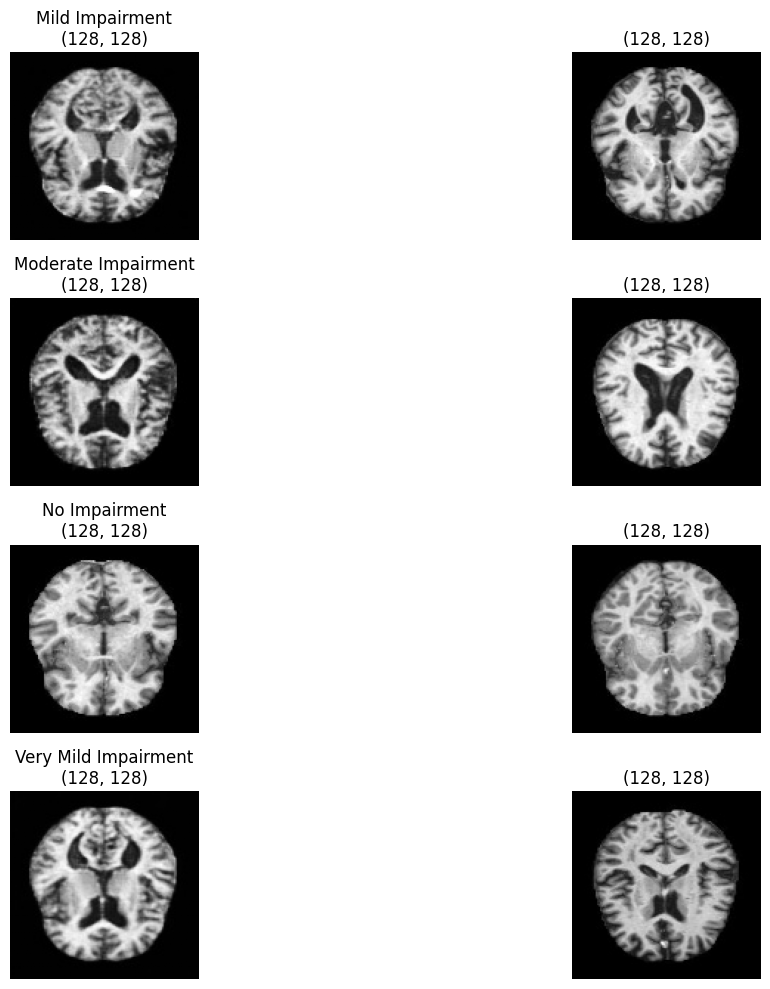

Using class weights: {0: 1.0, 1: 1.0, 2: 2.0, 3: 7.0}

Creating training generator with color_mode=grayscale...
Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.

Class indices: {'Mild Impairment': 0, 'Moderate Impairment': 1, 'No Impairment': 2, 'Very Mild Impairment': 3}

Creating improved 4-class model...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 8, 8, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1664)                │           6,656 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       1,704,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,018,826 (57.29 MB)

 Trainable params: 7,679,882 (29.30 MB)

 Non-trainable params: 7,338,944 (28.00 MB)


Training the improved 4-class model with weighted classes...
Epoch 1/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.3237 - auc_3: 0.5898 - loss: 4.9172
Epoch 1: val_accuracy improved from -inf to 0.41650, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 226s 210ms/step - accuracy: 0.3238 - auc_3: 0.5900 - loss: 4.9156 - val_accuracy: 0.4165 - val_auc_3: 0.7601 - val_loss: 1.7967 - learning_rate: 2.0000e-04
Epoch 2/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.5123 - auc_3: 0.7763 - loss: 2.6780
Epoch 2: val_accuracy improved from 0.41650 to 0.54834, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 92s 179ms/step - accuracy: 0.5124 - auc_3: 0.7763 - loss: 2.6777 - val_accuracy: 0.5483 - val_auc_3: 0.8338 - val_loss: 1.0858 - learning_rate: 2.0000e-04
Epoch 3/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5786 - auc_3: 0.8322 - loss: 2.1698
Epoch 3: val_accuracy improved from 0.54834 to 0.66895, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 144s 182ms/step - accuracy: 0.5786 - auc_3: 0.8323 - loss: 2.1697 - val_accuracy: 0.6689 - val_auc_3: 0.8653 - val_loss: 0.9205 - learning_rate: 2.0000e-04
Epoch 4/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6353 - auc_3: 0.8677 - loss: 1.8820
Epoch 4: val_accuracy did not improve from 0.66895
512/512 ━━━━━━━━━━━━━━━━━━━━ 90s 175ms/step - accuracy: 0.6353 - auc_3: 0.8677 - loss: 1.8820 - val_accuracy: 0.6484 - val_auc_3: 0.8667 - val_loss: 0.8055 - learning_rate: 2.0000e-04
Epoch 5/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6378 - auc_3: 0.8829 - loss: 1.7798
Epoch 5: val_accuracy did not improve from 0.66895
512/512 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - accuracy: 0.6379 - auc_3: 0.8829 - loss: 1.7797 - val_accuracy: 0.6514 - val_auc_3: 0.8616 - val_loss: 0.8195 - learning_rate: 2.0000e-04
Epoch 6/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6674 - auc_3: 0.9019 - loss: 1.6382
Epoch 6: val_accuracy did not imp

512/512 ━━━━━━━━━━━━━━━━━━━━ 140s 175ms/step - accuracy: 0.7057 - auc_3: 0.9243 - loss: 1.4220 - val_accuracy: 0.6724 - val_auc_3: 0.8826 - val_loss: 0.8419 - learning_rate: 2.0000e-04
Epoch 9/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7306 - auc_3: 0.9333 - loss: 1.3697
Epoch 9: val_accuracy did not improve from 0.67236
512/512 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - accuracy: 0.7306 - auc_3: 0.9333 - loss: 1.3697 - val_accuracy: 0.6460 - val_auc_3: 0.8726 - val_loss: 0.7697 - learning_rate: 2.0000e-04
Epoch 10/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7323 - auc_3: 0.9333 - loss: 1.3349
Epoch 10: val_accuracy improved from 0.67236 to 0.69922, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 91s 177ms/step - accuracy: 0.7323 - auc_3: 0.9333 - loss: 1.3349 - val_accuracy: 0.6992 - val_auc_3: 0.8967 - val_loss: 0.6290 - learning_rate: 2.0000e-04
Epoch 11/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7577 - auc_3: 0.9441 - loss: 1.1935
Epoch 11: val_accuracy did not improve from 0.69922
512/512 ━━━━━━━━━━━━━━━━━━━━ 141s 175ms/step - accuracy: 0.7577 - auc_3: 0.9441 - loss: 1.1936 - val_accuracy: 0.6465 - val_auc_3: 0.8714 - val_loss: 1.0051 - learning_rate: 2.0000e-04
Epoch 12/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7449 - auc_3: 0.9402 - loss: 1.2455
Epoch 12: val_accuracy did not improve from 0.69922
512/512 ━━━━━━━━━━━━━━━━━━━━ 90s 176ms/step - accuracy: 0.7449 - auc_3: 0.9402 - loss: 1.2455 - val_accuracy: 0.6958 - val_auc_3: 0.8890 - val_loss: 0.7153 - learning_rate: 2.0000e-04
Epoch 13/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7616 - auc_3: 0.9484 - loss: 1.1446
Epoch 13: val_accuracy did n

512/512 ━━━━━━━━━━━━━━━━━━━━ 90s 176ms/step - accuracy: 0.7653 - auc_3: 0.9526 - loss: 1.1061 - val_accuracy: 0.7114 - val_auc_3: 0.8963 - val_loss: 0.7264 - learning_rate: 2.0000e-04
Epoch 16/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7797 - auc_3: 0.9549 - loss: 1.0980
Epoch 16: val_accuracy improved from 0.71143 to 0.71680, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 91s 177ms/step - accuracy: 0.7797 - auc_3: 0.9549 - loss: 1.0979 - val_accuracy: 0.7168 - val_auc_3: 0.8821 - val_loss: 0.9756 - learning_rate: 2.0000e-04
Epoch 17/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7909 - auc_3: 0.9589 - loss: 1.0300
Epoch 17: val_accuracy did not improve from 0.71680

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
512/512 ━━━━━━━━━━━━━━━━━━━━ 89s 173ms/step - accuracy: 0.7909 - auc_3: 0.9589 - loss: 1.0301 - val_accuracy: 0.6982 - val_auc_3: 0.8925 - val_loss: 0.7166 - learning_rate: 2.0000e-04
Epoch 18/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8091 - auc_3: 0.9644 - loss: 0.9388
Epoch 18: val_accuracy did not improve from 0.71680
512/512 ━━━━━━━━━━━━━━━━━━━━ 90s 175ms/step - accuracy: 0.8091 - auc_3: 0.9644 - loss: 0.9388 - val_accuracy: 0.7119 - val_auc_3: 0.9009 - val_loss: 0.7398 - learning_rate: 1.0000e-04
Epoch 19/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step -

512/512 ━━━━━━━━━━━━━━━━━━━━ 141s 175ms/step - accuracy: 0.8360 - auc_3: 0.9720 - loss: 0.8263 - val_accuracy: 0.7217 - val_auc_3: 0.9039 - val_loss: 0.7182 - learning_rate: 1.0000e-04
Epoch 22/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8359 - auc_3: 0.9733 - loss: 0.8153
Epoch 22: val_accuracy improved from 0.72168 to 0.73389, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 143s 177ms/step - accuracy: 0.8359 - auc_3: 0.9733 - loss: 0.8153 - val_accuracy: 0.7339 - val_auc_3: 0.9071 - val_loss: 0.6987 - learning_rate: 1.0000e-04
Epoch 23/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8463 - auc_3: 0.9762 - loss: 0.7582
Epoch 23: val_accuracy did not improve from 0.73389
512/512 ━━━━━━━━━━━━━━━━━━━━ 90s 175ms/step - accuracy: 0.8463 - auc_3: 0.9762 - loss: 0.7582 - val_accuracy: 0.7119 - val_auc_3: 0.8886 - val_loss: 0.8487 - learning_rate: 1.0000e-04
Epoch 24/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8557 - auc_3: 0.9769 - loss: 0.7491
Epoch 24: val_accuracy did not improve from 0.73389

Epoch 24: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
512/512 ━━━━━━━━━━━━━━━━━━━━ 144s 178ms/step - accuracy: 0.8557 - auc_3: 0.9769 - loss: 0.7491 - val_accuracy: 0.7319 - val_auc_3: 0.9091 - val_loss: 0.7050 - learning_rate: 1.0000e-04
Epoch 25/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

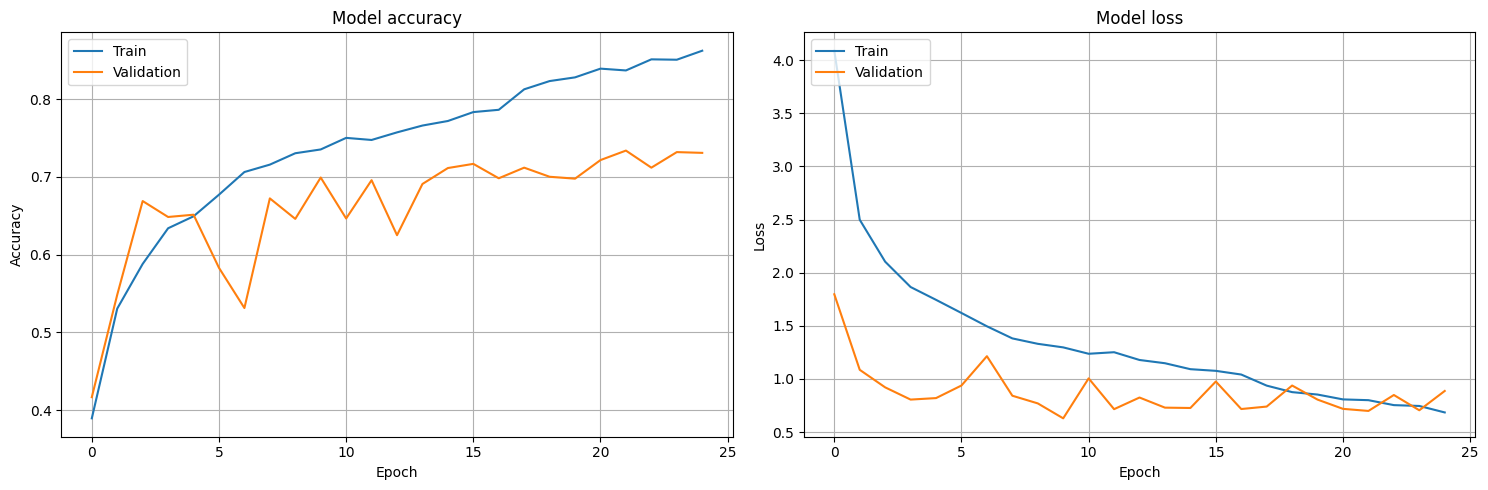


Evaluating the improved model...
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step


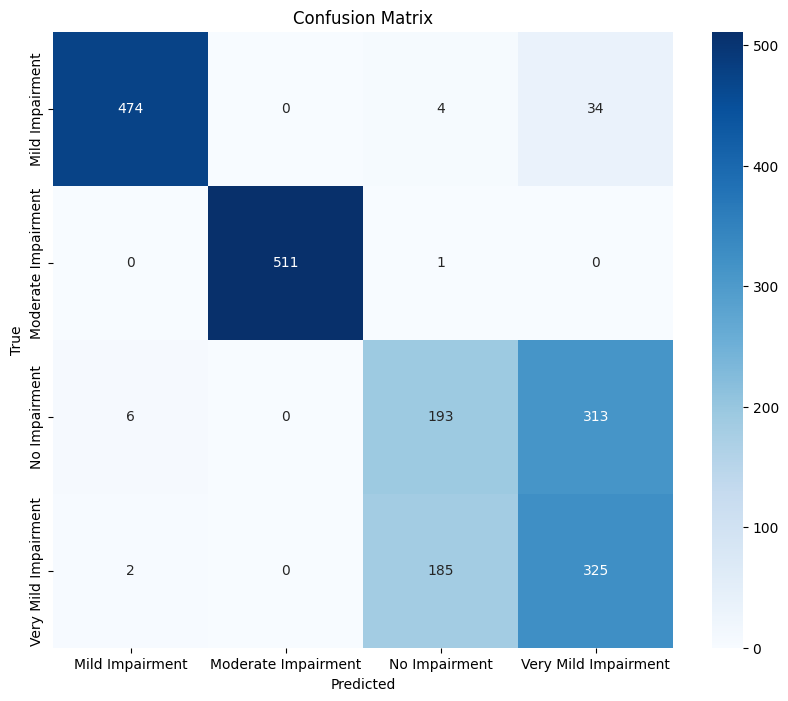


Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.93      0.95       512
 Moderate Impairment       1.00      1.00      1.00       512
       No Impairment       0.50      0.38      0.43       512
Very Mild Impairment       0.48      0.63      0.55       512

            accuracy                           0.73      2048
           macro avg       0.74      0.73      0.73      2048
        weighted avg       0.74      0.73      0.73      2048

Class Mild Impairment accuracy: 0.9258
Class Moderate Impairment accuracy: 0.9980
Class No Impairment accuracy: 0.3770
Class Very Mild Impairment accuracy: 0.6348


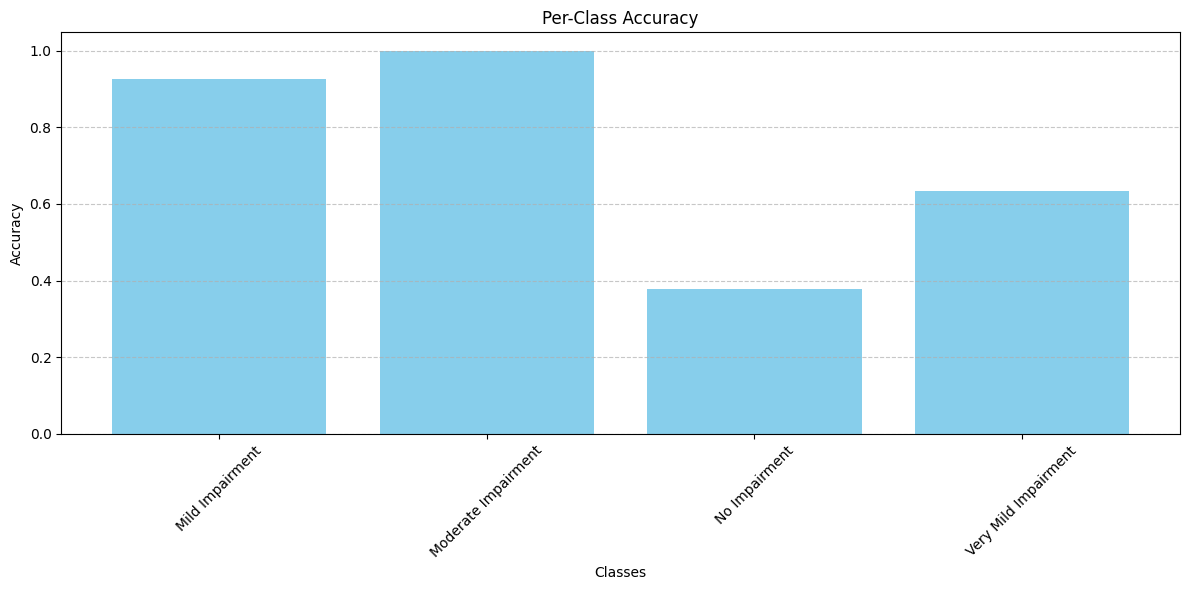


Analyzing confusion for worst performing class: No Impairment
Found 319 misclassified samples for class No Impairment


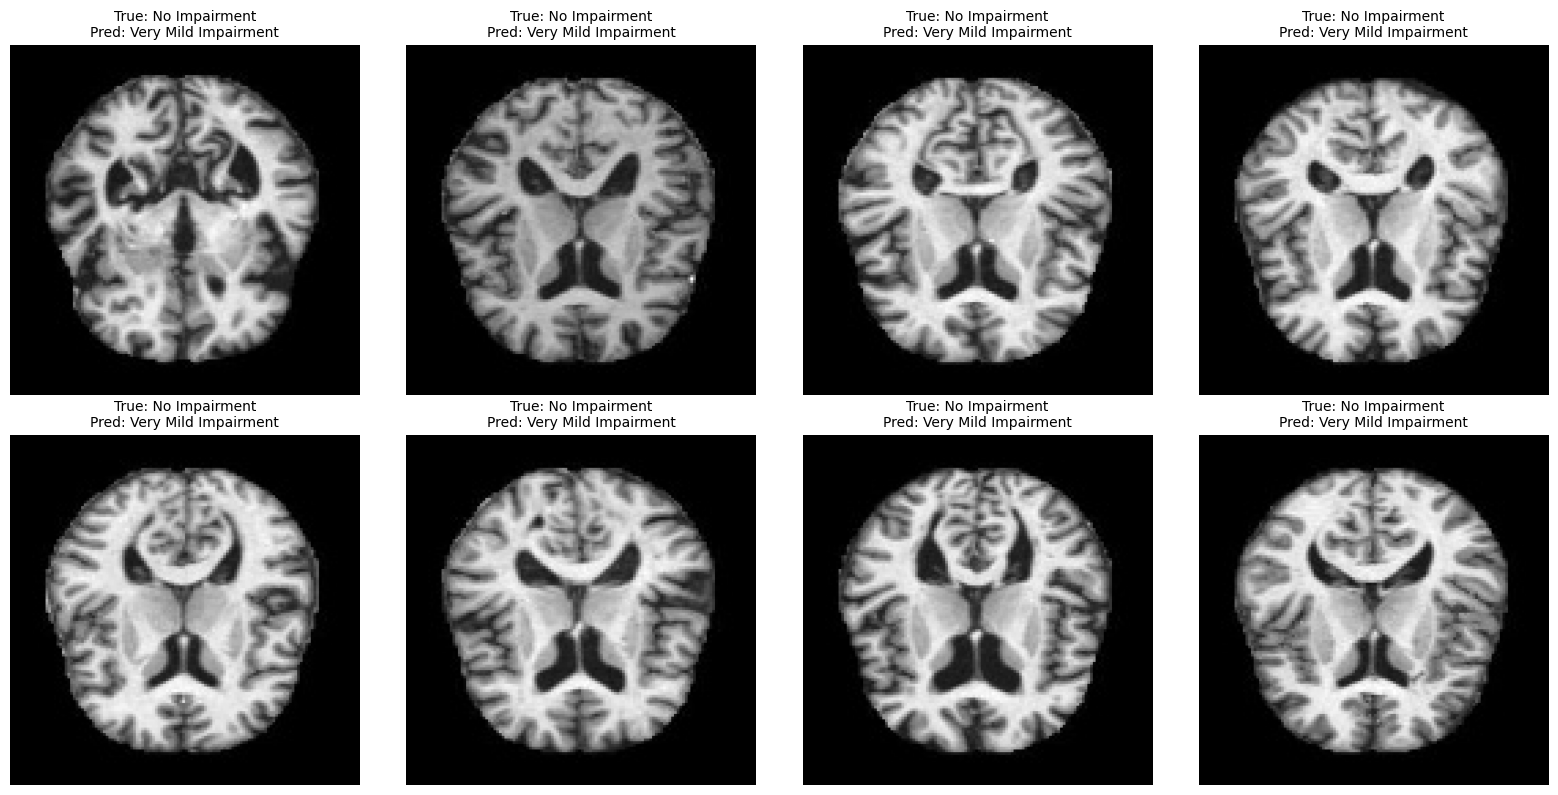

In [ ]:
if __name__ == "__main__":
    main()